# Two electrons on a ring

In [1]:
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from tqdm import tqdm

## a) Properties of the wave function
- antisymmetric: $$\psi(x_1, x_2) = -\psi(x_2, x_1)$$
- periodic: $$\forall n, m \in \mathbb{Z}: \quad \psi(x_1 + 2\pi n, x_2 + 2\pi m) = \psi(x_1, x_2)$$
- normalized: $$\iint_0^{2\pi} |\psi(x_1, x_2)|^2 \, \mathrm dx_1 \, \mathrm dx_2 = 1$$

## b) Limiting cases
- small electrostatic interaction: wave function almost constant on the ring to minimize the kinetic energy
- large electrostatic interaction: wave function only non-zero if the electrons are antipodal

## c) Discretized Hamiltonian
$$H = -\frac{1}{2} (\nabla_1^2 + \nabla_2^2) + V$$
The potential energy $V$ can just be evaluated on a grid.
The Laplace operator in polar coordinates is given by
$$\nabla^2 = \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial}{\partial r} \right) + \frac{1}{r^2} \frac{\partial^2}{\partial \phi^2}$$
As $r = 1$ is constant, the first term vanishes and we are left with
$$\nabla^2 = \frac{\partial^2}{\partial \phi^2}$$

We approximate the second derivative with a finite difference scheme,
$$\frac{\partial^2 f}{\partial x^2} \approx \frac{f'(x+h/2) - f'(x-h/2)}{h} \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}.$$
This yields the Laplace operator
$$L = \frac{1}{\Delta x^2} \begin{pmatrix}
    -2 & 1 & & & & \cdots & & 1 \\
    1 & -2 & 1 & & & \cdots & & \\
    & 1 & -2 & 1 & & \cdots & & \\
    & & 1 & -2 & 1 & \cdots & & \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    1 & & & & & \cdots & 1 & -2 \\
\end{pmatrix}.$$
So we can write the discretized Hamiltonian as
$$H = -\frac{1}{2} (L \cdot + \cdot L) + V$$
where $L \cdot$ denotes multiplication from the left and $\cdot L$ from the right (see expression for the energy below).

In [2]:
M = 100
x = torch.linspace(0, 2*torch.pi, M+1)[:-1]  # discretized domain [0, 1)
delta_x = x[1] - x[0]

laplace = torch.diag(-2*torch.ones(M)) + torch.diag(torch.ones(M-1), 1) + torch.diag(torch.ones(M-1), -1)
laplace[0, -1] = 1
laplace[-1, 0] = 1

print("laplace:\n", laplace)
laplace /= delta_x**2

laplace:
 tensor([[-2.,  1.,  0.,  ...,  0.,  0.,  1.],
        [ 1., -2.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  1., -2.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  1., -2.,  1.],
        [ 1.,  0.,  0.,  ...,  0.,  1., -2.]])



$$E(\psi) = \sum_{ij} \psi_{ij} \left(- \frac{1}{2} \sum_k L_{ik} \psi_{kj} - \frac{1}{2} \sum_k \psi_{ik} L_{kj} + \frac{k}{r_{ij}} \psi_{ij} \right)$$

$$\nabla E(\psi) = -(L \psi + \psi L) + 2 \,\mathrm{Tr}\, (V \psi)$$

In [3]:
# potential Matrix
epsilon = 0.01  # Avoid division by zero
coords = torch.stack([torch.cos(x), torch.sin(x)], dim=1)
r12 = torch.linalg.norm(coords[None] - coords[:, None], axis=-1)
V = 1 / (r12 + epsilon)

def energy_function(psi: torch.Tensor, k: float = 1):
    """Energy function for the two-electron system on a ring.
    
    Args:
        psi (torch.Tensor): Wave function of the two-electron system.
        k (float, optional): Strength of the electrostatic interaction. Defaults to 1.
    """
    return torch.sum(psi * (- 0.5 * laplace @ psi - 0.5 * psi @ laplace + k * V * psi))


## d)

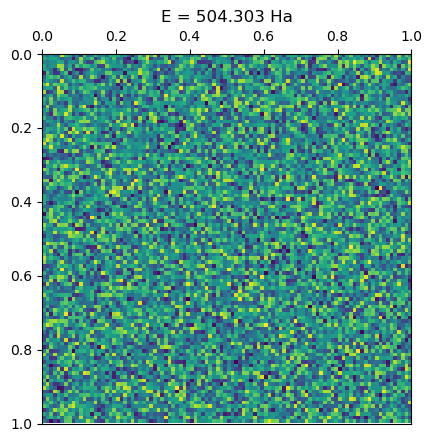

In [4]:
psi_rand = torch.rand(M, M)
psi_rand = psi_rand - psi_rand.T  # antisymmetrize
psi_rand /= torch.norm(psi_rand)  # normalize


plt.gca().xaxis.tick_top()
plt.imshow(psi_rand, extent=(0, 1, 1, 0))
plt.title(f"E = {energy_function(psi_rand, 1):.3f} Ha")
plt.show()

## e)

In [5]:
def gradient_descent(psi: torch.Tensor, k: float = 1, lr: float = 0.0001, n_iterations: int = 1000) -> tuple[torch.Tensor, list[float]]:
    energies = []
    for _ in tqdm(range(n_iterations)):
        energy = energy_function(psi, k)
        gradient = - (laplace @ psi + psi @ laplace) + 2 * k * V * psi
        
        psi = psi - lr * gradient
        psi = psi / torch.norm(psi)  # Normalize Psi at each step
        energies.append(energy)

        assert torch.allclose(psi, -psi.T, atol=1e-4), f"psi is not antisymmetric: {torch.max(torch.abs(psi + psi.T))}"

    return psi, energies

In [6]:
def plot_psi_and_energies(psi: torch.Tensor, energies: list[float], k: float):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.gca().xaxis.tick_top()
    plt.imshow(psi.detach(), extent=(0, 1, 1, 0))
    plt.title(f"Final wave function, $E =$ {energies[-1]:.3f} Ha")
    plt.plot([0.5, 1], [0, 0.5], 'k:', lw=1)
    plt.plot([0, 0.5], [0.5, 1], 'k:', lw=1)

    plt.subplot(1, 2, 2)
    plt.plot(energies)
    plt.xlabel("Iteration")
    plt.ylabel("Energy [Ha]")
    plt.grid(True)
    plt.yscale('log')
    plt.title(f"Energies for $k =$ {k}")
    
    plt.tight_layout()
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:09<00:00, 2187.38it/s]


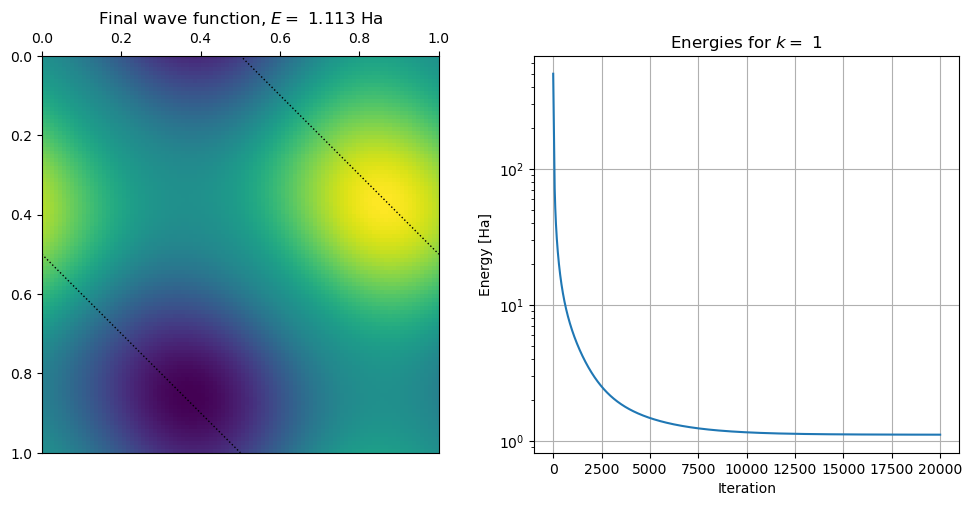

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:08<00:00, 2253.05it/s]


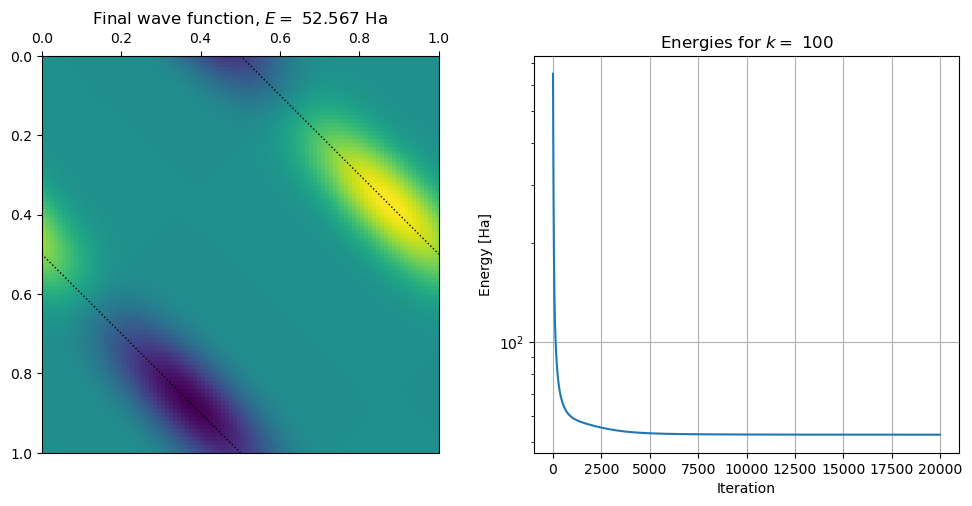

In [7]:
for k in [1, 100]:
    psi_opt, energies_gd = gradient_descent(psi_rand, k=k, lr=0.00005, n_iterations=20000)
    plot_psi_and_energies(psi_opt, energies_gd, k=k)

## f)

As we can see in the plots above, a Slater determinant can't represent the wave function in the limit of strong electrostatic interaction.

## g)

The memory footprint of the wave function with $n$ electrons is $O(M^n)$, where $M$ is the number of discretization points on the ring. This exponential scaling makes it infeasible to use the wave function ansatz for more than a few electrons.

In [8]:
for n in [2, 10, 100]:
    n_matrix_elements = M**n
    byte_per_element = 4  # 32 bit float
    memory_footprint = n_matrix_elements * byte_per_element / 1e6  # MB
    print(f"Memory footprint for {n} electrons: {memory_footprint:.2f} MB")

Memory footprint for 2 electrons: 0.04 MB
Memory footprint for 10 electrons: 400000000000000.00 MB
Memory footprint for 100 electrons: 399999999999999977863869755018784683065311503640472948595884460471417406452712536274477508433826017624018112358745658838154250997959106484708460014918698592321517890213709695617850834403219996672.00 MB


## h)

In [9]:
def gradient_descent_torch(psi: torch.Tensor, k: float = 1, lr: float = 0.0001, n_iterations: int = 1000) -> tuple[torch.Tensor, list[float]]:
    energies = []
    psi = psi.clone()
    psi.requires_grad = True
    optimizer = torch.optim.SGD([psi], lr=lr, momentum=0.9)

    for _ in tqdm(range(n_iterations)):
        energy = energy_function(psi, k)
        energies.append(energy.item())

        optimizer.zero_grad()
        energy.backward()
        optimizer.step()

        # Normalize psi in a way that preserves gradient computation
        psi.data = psi.data / psi.norm()

        assert torch.allclose(psi, -psi.T, atol=1e-4), f"psi is not antisymmetric: {torch.max(torch.abs(psi + psi.T))}"

    return psi.detach(), energies

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1206.01it/s]


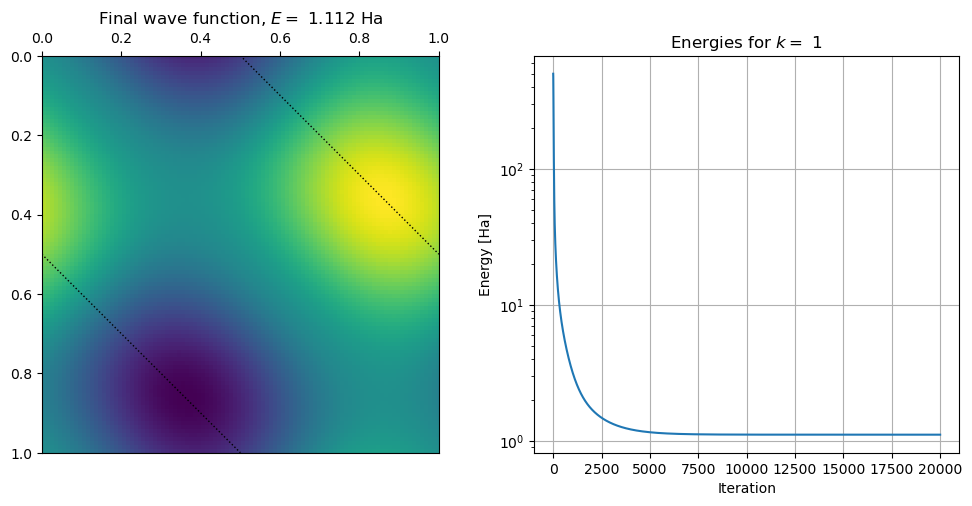

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1094.51it/s]


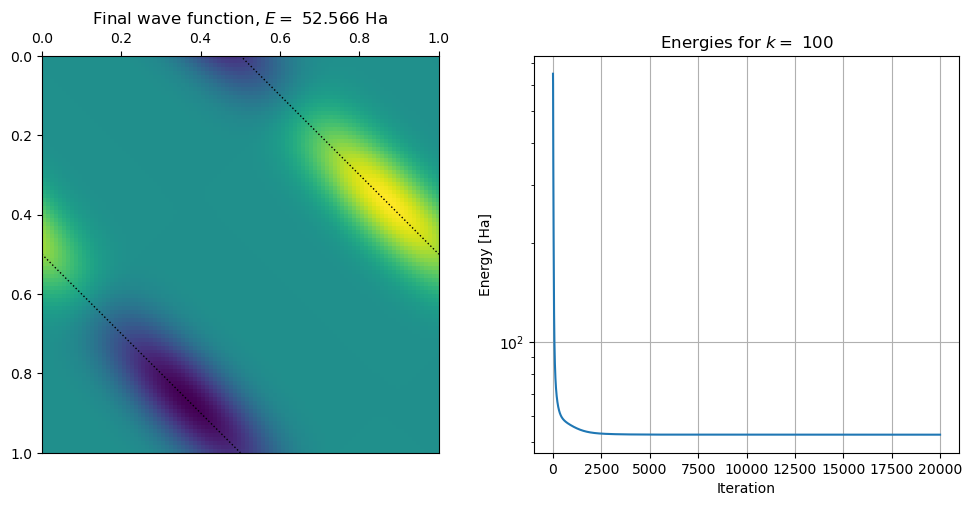

In [10]:
for k in [1, 100]:
    psi_opt, energies_gd = gradient_descent_torch(psi_rand, k=k, lr=0.00001, n_iterations=20000)
    plot_psi_and_energies(psi_opt, energies_gd, k=k)

## i) Using Slater determinants

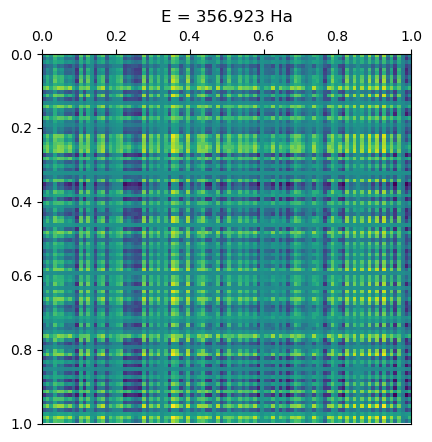

In [11]:
phi_1_rand = torch.rand(M)
phi_2_rand = torch.rand(M)

psi_rand_sd = torch.outer(phi_1_rand, phi_2_rand) - torch.outer(phi_2_rand, phi_1_rand)
psi_rand_sd = psi_rand_sd / torch.norm(psi_rand_sd)

plt.gca().xaxis.tick_top()
plt.imshow(psi_rand_sd, extent=(0, 1, 1, 0))
plt.title(f"E = {energy_function(psi_rand_sd, 1):.3f} Ha")
plt.show()

### Using own optimizer

In [12]:
def gradient_descent_sd(phi_1: torch.Tensor, phi_2: torch.Tensor, k: float = 100, lr: float = 0.0001, n_iterations: int = 1000) -> tuple[torch.Tensor, list[float]]:
    energies = []
    phi_1 = phi_1.clone()
    phi_2 = phi_2.clone()
    
    for _ in tqdm(range(n_iterations)):
        phi_1.requires_grad = True
        phi_2.requires_grad = True
        psi = torch.outer(phi_1, phi_2) - torch.outer(phi_2, phi_1)
        psi = psi / torch.norm(psi)
        
        energy = energy_function(psi, k)
        energy.backward()
        energies.append(energy.item())

        phi_1 = phi_1 - lr * phi_1.grad
        phi_2 = phi_2 - lr * phi_2.grad

        phi_1 = phi_1.detach()
        phi_2 = phi_2.detach()

        assert torch.allclose(psi, -psi.T, atol=1e-4), f"psi is not antisymmetric: {torch.max(torch.abs(psi + psi.T))}"
        
    return psi.detach(), energies

100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:42<00:00, 1179.88it/s]


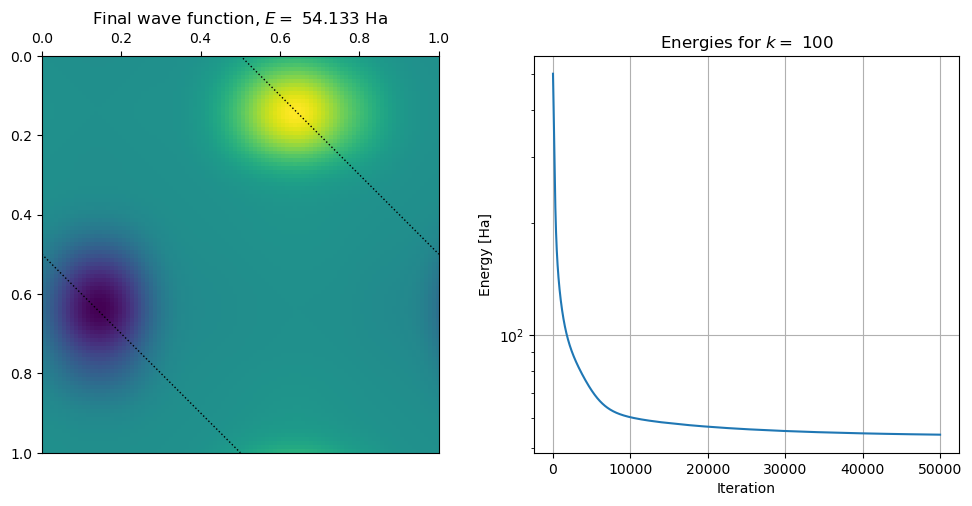

In [13]:
psi_opt_sd, energies_gd_sd = gradient_descent_sd(phi_1_rand, phi_2_rand, k=100, lr=0.00005, n_iterations=50000)
plot_psi_and_energies(psi_opt_sd, energies_gd_sd, k=100)

### Using torch optimizer

In [14]:
def gradient_descent_sd_torch(phi_1: torch.Tensor, phi_2: torch.Tensor, k: float = 100, lr: float = 0.0001, n_iterations: int = 1000) -> tuple[torch.Tensor, list[float]]:
    energies = []
    phi_1 = phi_1.clone()
    phi_2 = phi_2.clone()
    phi_1.requires_grad = True
    phi_2.requires_grad = True
    
    optimizer = torch.optim.SGD([phi_1, phi_2], lr=lr, momentum=0.9)
    
    for _ in tqdm(range(n_iterations)):
        psi = torch.outer(phi_1, phi_2) - torch.outer(phi_2, phi_1)
        psi = psi / torch.norm(psi)
        
        energy = energy_function(psi, k)
        energy.backward()
        energies.append(energy.item())

        optimizer.step()
        optimizer.zero_grad()
        
        assert torch.allclose(psi, -psi.T, atol=1e-4), f"psi is not antisymmetric: {torch.max(torch.abs(psi + psi.T))}"
        
    return psi.detach(), energies

100%|██████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 749.18it/s]


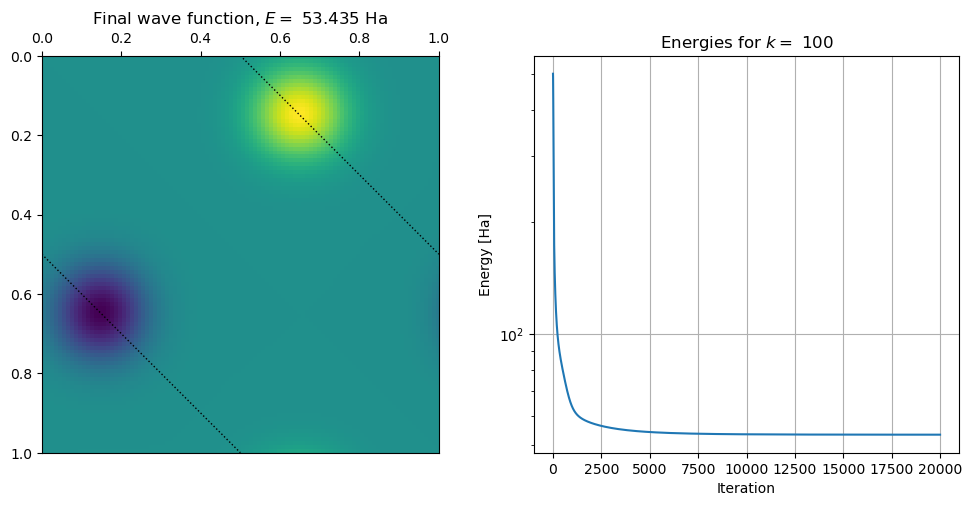

In [15]:
psi_opt_sd, energies_gd_sd = gradient_descent_sd_torch(phi_1_rand, phi_2_rand, k=100, lr=0.00005, n_iterations=20000)
plot_psi_and_energies(psi_opt_sd, energies_gd_sd, k=100)

## On a torus

In [16]:
# import matplotlib as mpl
# mpl.use('TkAgg')
%matplotlib notebook

In [17]:
def plot_on_torus(psi: torch.Tensor):
    # generate torus mesh
    angle = torch.linspace(0, 2 * torch.pi, 100)
    theta, phi = torch.meshgrid(angle, angle, indexing="ij")
    r, R = .5, 1.
    X = (R + r * torch.cos(phi)) * torch.cos(theta)
    Y = (R + r * torch.cos(phi)) * torch.sin(theta)
    Z = r * torch.sin(phi)
    
    # apply a colormap to the normalized color values
    norm = Normalize(vmin=psi.min().item(), vmax=psi.max().item())
    cmap = plt.get_cmap("viridis")
    normalized_colors = cmap(norm(psi))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=normalized_colors)
    ax.set_aspect("equal")
    plt.show()

<IPython.core.display.Javascript object>


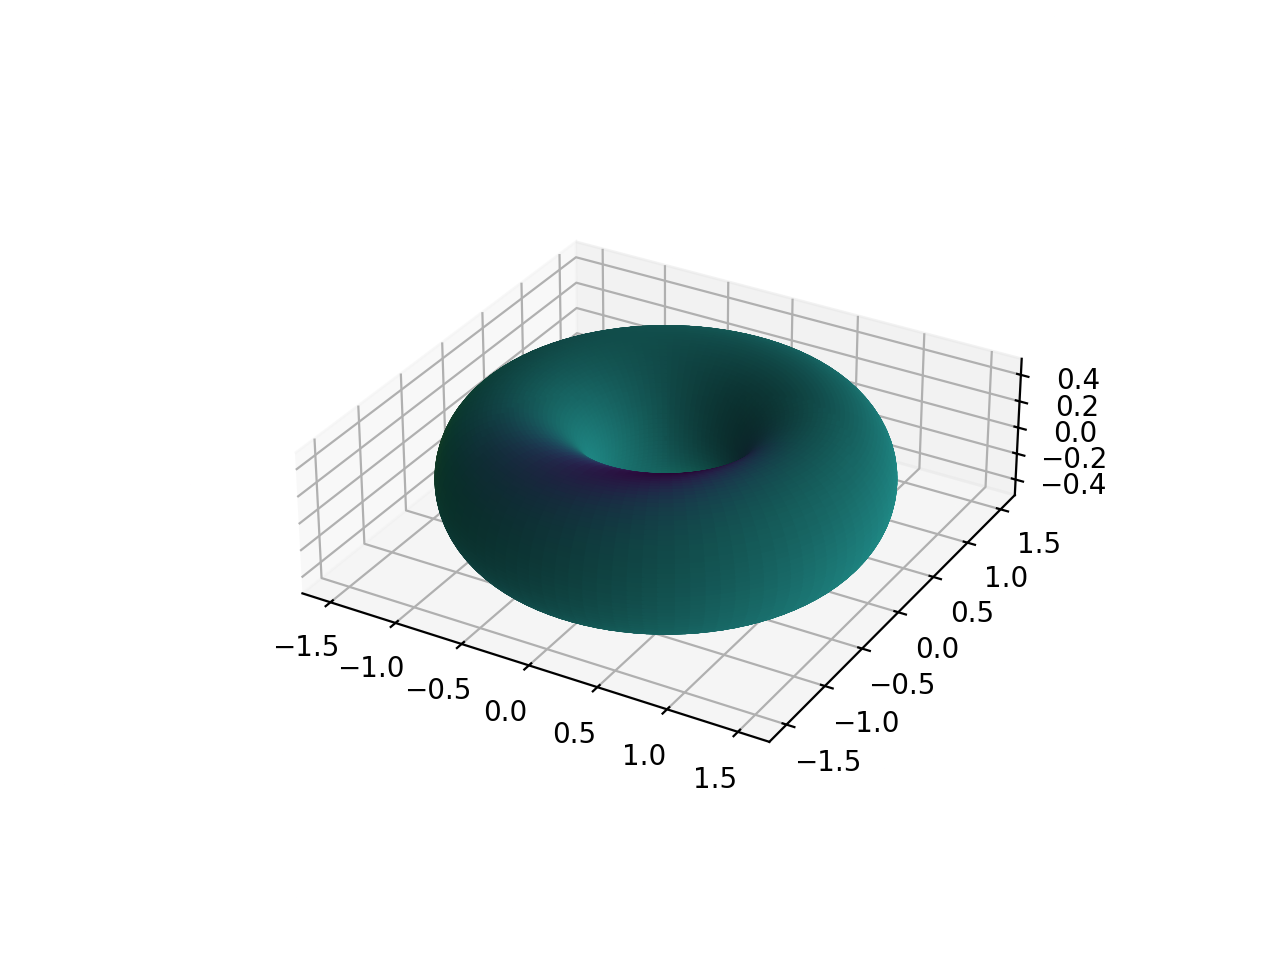

In [18]:
plot_on_torus(psi_opt)